<a href="https://colab.research.google.com/github/vdovetzi/NLP_Language_Detection/blob/main/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Постановка задачи и формулировка задания

Имеется $dataset$ с предложениями на разных языках. Хочется обучить модель, которая сможеть решать задачу $language$ $detection$.

**Формулировка задания:**

*  На вход подается предложение $sentence$.
*  Вызов функции $predict(sentence)$ выводит на экран, на каком языке написано предложение.



# Необходимая теория

1. Bag of Words;
2. Выборки: тестовая и тренировочная;
3. Модель;
4. Владение keras;
5. Понимание того, как работает нейронная сеть;
6. Наивные байесовские классификаторы;
7. Классификаторы;
8. Оптимизаторы;
9. Алгоритм обратного распространения ошибки



# Используемые инструменты

В своей работе я буду использовать следующие инструменты:



*   Библиотека $pandas$ для обработки и анализа данных
*   Библиотека $numpy$ для линала
* Библиотека $re$ для регулярных выражений
* Библиотека $seaborn$ для красивых визуализаций
* Библиотека $matplotlib.pyplot$ для построений графиков
* Библиотека $string$, чтобы воспользоваться $string.punctuation$
* Библиотека $nltk$ нужна для всего, так как это основной инструмент
* Библиотека $sklearn.model$_$selection$ для разбиения на выборки
* Библиотека $sklearn.feature$_$extraction.text$ для использования модели $Bag$ $of$ $Words$ и использования $TF-IDF$ метрики
* Библиотека $sklearn.naive$_$bayes$ для наивного байесовского классификатора
* Библиотека $sklearn.metrics$ для оценки качества модели
* Библиотека $sklearn$ для $pipeline$
* Библиотека $sklearn.linear$_$model$ для алгоритма обучения $LogisticRegression$
* Библиотека $keras$ для использования более умных нейросетей
* Библиотека $tensorflow$, чтобы пользоваться нейросетями на более низком уровне



In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import pipeline
from sklearn.linear_model import LogisticRegression
import keras
import tensorflow as tf
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Посмотрим поподробнее на имеющийся $dataset$

In [4]:
dataset = pd.read_csv("Language Detection.csv")
dataset.head(10) # возращает первые 10 строчек

,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English
5,"[2] In ancient philosophy, natura is mostly us...",English
6,"[3][4] \nThe concept of nature as a whole, the...",English
7,During the advent of modern scientific method ...,English
8,"[5][6] With the Industrial revolution, nature ...",English
9,"However, a vitalist vision of nature, closer t...",English


Как можем заметить, мы имеем формат **предложение** - **язык**.

Посмотрим теперь на то, какие языки мы вообще имеем в нашем $dataset$. Изобразим это в виде красивой столбчатой и круговой диаграмок.

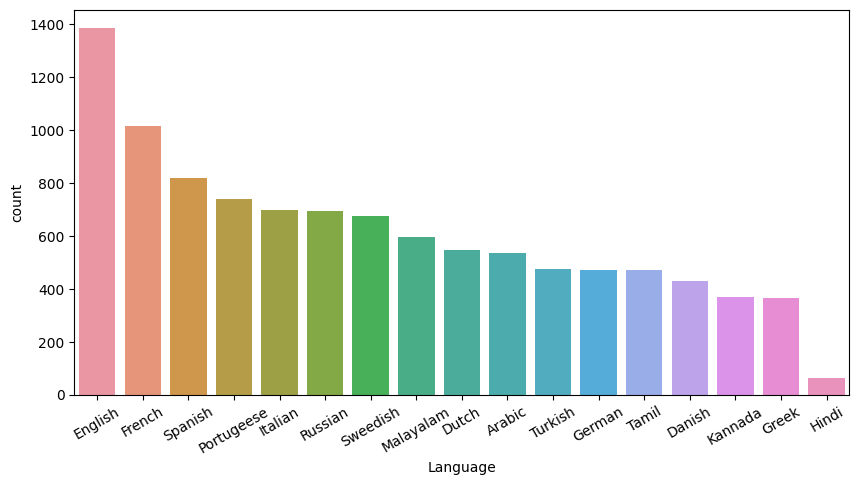

In [5]:
plt.figure(figsize=(10, 5))
sns.countplot(data= dataset, x="Language", order=dataset["Language"].value_counts().index)
plt.xticks(rotation=30)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

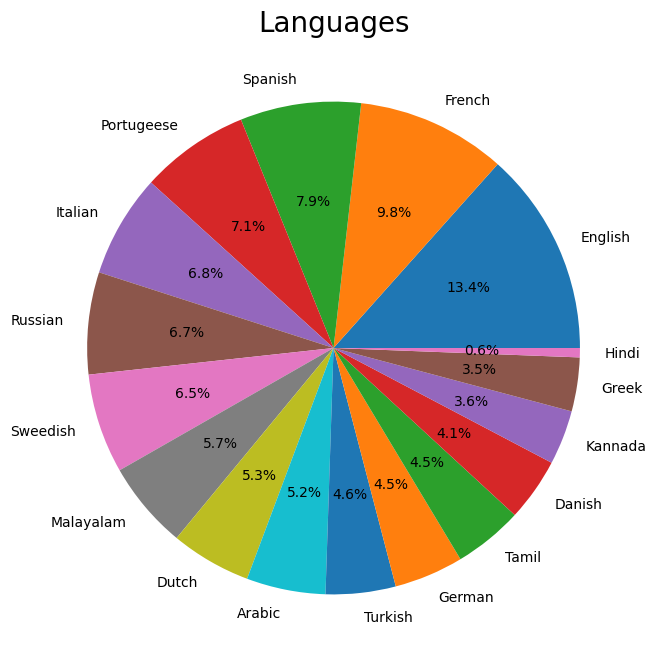

In [6]:
plt.figure(figsize=(8,8))
plt.pie(x = dataset['Language'].value_counts() ,autopct='%1.1f%%' ,labels=dataset['Language'].value_counts().index)
plt.title('Languages',fontsize=20)
plt.show

In [7]:
dataset["Language"].value_counts()

English       1385
French        1014
Spanish        819
Portugeese     739
Italian        698
Russian        692
Sweedish       676
Malayalam      594
Dutch          546
Arabic         536
Turkish        474
German         470
Tamil          469
Danish         428
Kannada        369
Greek          365
Hindi           63
Name: Language, dtype: int64

# Text Preprocessing

**Text** **Cleaning**

In [8]:
def Cleaner(text):
  # удалим все цифры и иные символы, кроме букв и приведём текст к нижнему регистру
  text = re.sub(r'[{}]'.format(string.punctuation), '', text)
  text = re.sub(r'\d+', '', text)
  return text.lower()


Может быть такое, что в нашем $dataset$ в каком-то предложении помимо основного языка, на котором оно написано есть и другие языки, например английский или русский, поэтому напишем функции, которые будут удалять эти побочные языки из предложения.

Понятно, что вариантов очень много, но кажется, что основным является английский, так как есть куча аббревиатур или каких-то названий, которые невозмомножно перевести на другой язык, поэтому их оставляют на английском.

Так что я считаю, что достаточно написать функцию, удаляющую английские символы.

In [9]:
def RemoveEnglish(text):
        text = re.sub(r'[a-zA-Z]+', '', text)
        return text.lower()

In [10]:
# функция, которая применяет к предложению функцию RemoveEnglish
def ApplyToSentence(sentence):
  if (sentence.Language != 'English'):
    sentence.Text = RemoveEnglish(sentence.Text)
  return sentence.Text

In [11]:
data = dataset.copy()
X = data.apply(ApplyToSentence, axis = 1) #axis = 1, так как применять функцию надо к столбцу
X = X.apply(Cleaner) # применяем Cleaner к столбцу с предложениями

y = data["Language"]



Посмотрим, что получилось:

In [12]:
X

0         nature in the broadest sense is the natural p...
1        nature can refer to the phenomena of the physi...
2        the study of nature is a large if not the only...
3        although humans are part of nature human activ...
4         the word nature is borrowed from the old fren...
                               ...                        
10332    ನಿಮ್ಮ ತಪ್ಪು ಏನು ಬಂದಿದೆಯೆಂದರೆ ಆ ದಿನದಿಂದ ನಿಮಗೆ ಒ...
10333    ನಾರ್ಸಿಸಾ ತಾನು ಮೊದಲಿಗೆ ಹೆಣಗಾಡುತ್ತಿದ್ದ ಮಾರ್ಗಗಳನ್...
10334    ಹೇಗೆ  ನಾರ್ಸಿಸಿಸಮ್ ಈಗ ಮರಿಯನ್ ಅವರಿಗೆ ಸಂಭವಿಸಿದ ಎಲ...
10335    ಅವಳು ಈಗ ಹೆಚ್ಚು ಚಿನ್ನದ ಬ್ರೆಡ್ ಬಯಸುವುದಿಲ್ಲ ಎಂದು ...
10336    ಟೆರ್ರಿ ನೀವು ನಿಜವಾಗಿಯೂ ಆ ದೇವದೂತನಂತೆ ಸ್ವಲ್ಪ ಕಾಣು...
Length: 10337, dtype: object

In [13]:
y

0        English
1        English
2        English
3        English
4        English
          ...   
10332    Kannada
10333    Kannada
10334    Kannada
10335    Kannada
10336    Kannada
Name: Language, Length: 10337, dtype: object

# Выбор модели

Первая модель - **Bag of Words** + ***MultinomialNB*** из наивных байесовских моделей c минимальной предобработкой текста

In [14]:
x=np.array(dataset["Text"])
y=np.array(dataset["Language"])

d={}
i=0
for word in pd.unique(y):
    d[word]=i
    i+=1

In [15]:
# Bag of Words с помощью CountVectorizer
cv=CountVectorizer()
x=cv.fit_transform(x)

In [16]:
# Выборки
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=42)

In [17]:
model = MultinomialNB()
model.fit(x_train, y_train)

MultinomialNB()

In [18]:
y_pred = model.predict(x_test) # делаем предугадывание

In [19]:
ac1 = accuracy_score(y_test,y_pred)
cr1 = classification_report(y_test, y_pred)

In [20]:
print("Accuracy is ", ac1)

Accuracy is  0.9825918762088974


In [21]:
print(cr1)

              precision    recall  f1-score   support

      Arabic       1.00      0.98      0.99       106
      Danish       0.97      0.96      0.97        73
       Dutch       0.98      0.97      0.98       111
     English       0.92      1.00      0.96       291
      French       0.99      0.99      0.99       219
      German       1.00      0.97      0.98        93
       Greek       1.00      0.99      0.99        68
       Hindi       1.00      1.00      1.00        10
     Italian       1.00      0.99      1.00       145
     Kannada       1.00      1.00      1.00        66
   Malayalam       1.00      0.98      0.99       121
  Portugeese       0.99      0.98      0.99       144
     Russian       1.00      0.99      1.00       136
     Spanish       0.99      0.97      0.98       160
    Sweedish       1.00      0.98      0.99       133
       Tamil       1.00      0.99      0.99        87
     Turkish       1.00      0.93      0.97       105

    accuracy              

**Анализ ошибок**

Как можем заметить по cr1, у нас модель обучилась практически идеально и если и есть ошибки, то это в основном на English.

Связано это может быть с тем, что в других предложениях встречаются несколько английских слов (аббревиатуры и тд) и это снижает точность определения английского языка. То есть скорее всего есть такие предложения, написанные на латинских языках, по типу Dutch, French, Portoguese и др, что наша нейросеть путает их с английским или наоборот.

Найти пример не из тестовой выборки будет довольно трудно, а в тестовой выборке можно поискать.

На самом деле лучше всего понять где наша нейросеть ошибается можно на Confusion Matrix, поэтому давайте её построим

In [22]:
cm1 = confusion_matrix(y_test, y_pred)

[Text(0, 0.5, 'English'),
 Text(0, 1.5, 'Malayalam'),
 Text(0, 2.5, 'Hindi'),
 Text(0, 3.5, 'Tamil'),
 Text(0, 4.5, 'Portugeese'),
 Text(0, 5.5, 'French'),
 Text(0, 6.5, 'Dutch'),
 Text(0, 7.5, 'Spanish'),
 Text(0, 8.5, 'Greek'),
 Text(0, 9.5, 'Russian'),
 Text(0, 10.5, 'Danish'),
 Text(0, 11.5, 'Italian'),
 Text(0, 12.5, 'Turkish'),
 Text(0, 13.5, 'Sweedish'),
 Text(0, 14.5, 'Arabic'),
 Text(0, 15.5, 'German'),
 Text(0, 16.5, 'Kannada')]

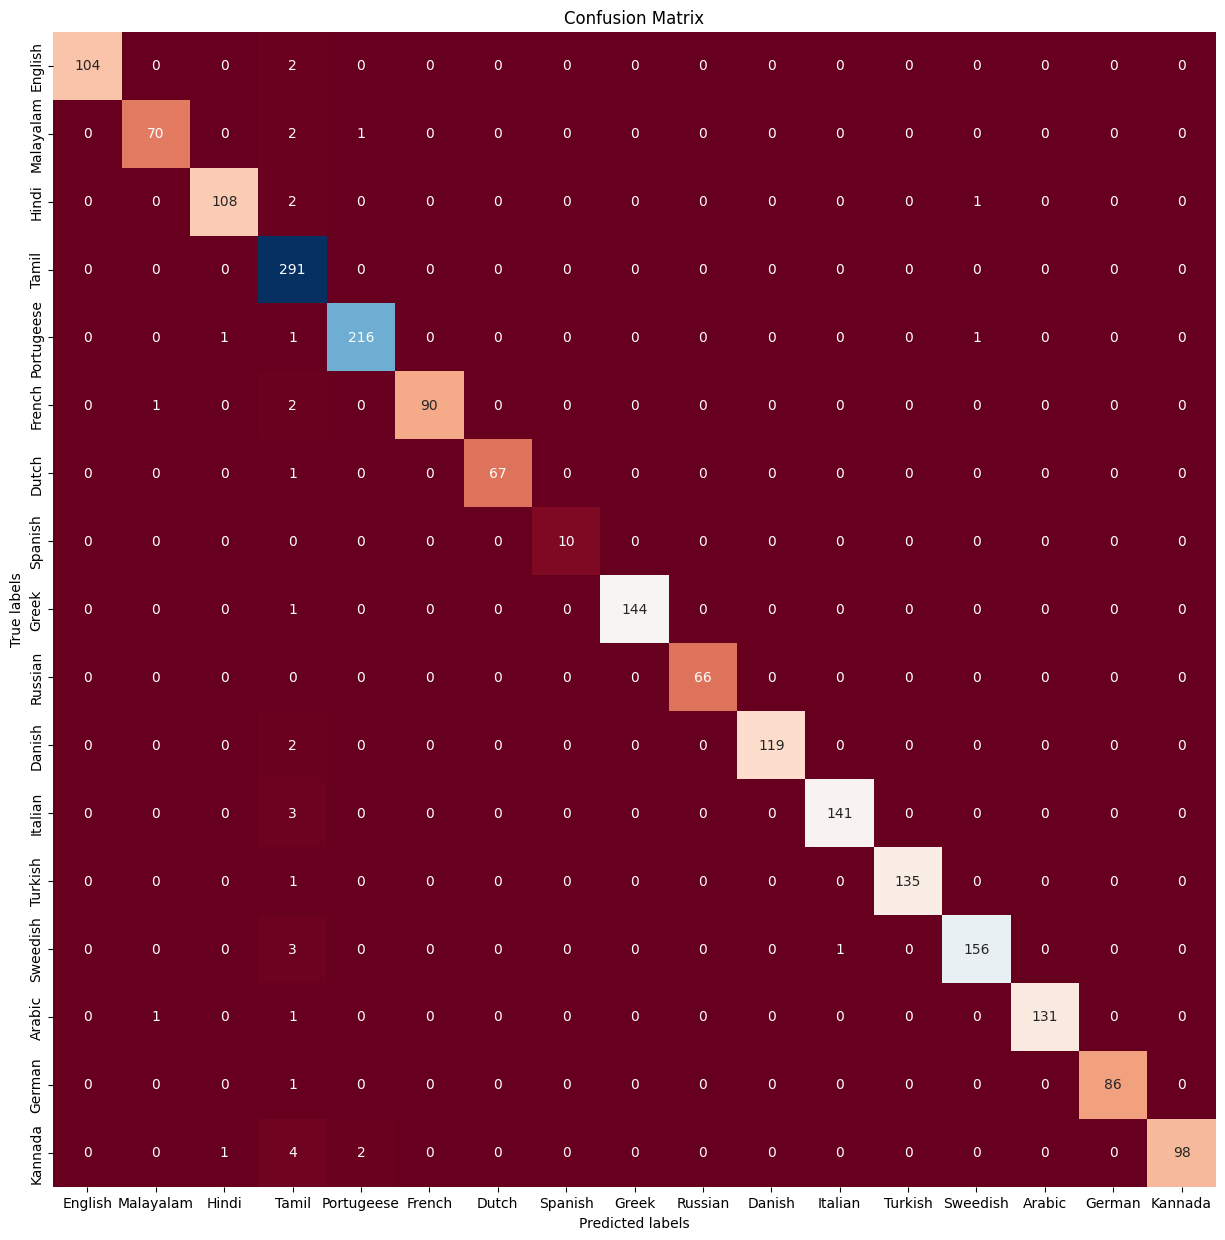

In [23]:
plt.figure(figsize=(15,15))
ax= plt.subplot()
sns.heatmap(cm1, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(d.keys())
ax.yaxis.set_ticklabels(d.keys())

Вторая модель - это ***TF-IDF + LogisticRegression***

In [24]:
# Подправим немного тестовую и тренировочную выборки
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [25]:
# Воспользуемся TF-IDF метрикой
vectorizer = TfidfVectorizer(ngram_range=(1,3), analyzer='char')

In [26]:
# используем pipeline, так как она позволяем последовательно применить несколько transforms, чтобы получить в итоге один final estimator
model = pipeline.Pipeline([
    ('vectorizer', vectorizer),
    ('clf', LogisticRegression())
])

In [27]:
# обучаем модель
model.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char', ngram_range=(1, 3))),
                ('clf', LogisticRegression())])

In [28]:
# предсказываем
y_pred = model.predict(x_test)

In [29]:
ac2 = accuracy_score(y_test, y_pred)
cr2 = classification_report(y_test, y_pred)

In [30]:
print("Accuracy is ", ac2)

Accuracy is  0.8499032882011606


In [31]:
print(cr2)

              precision    recall  f1-score   support

      Arabic       1.00      0.99      1.00       134
      Danish       0.90      0.68      0.78        97
       Dutch       0.32      0.96      0.48       139
     English       1.00      1.00      1.00       364
      French       0.88      0.79      0.83       269
      German       0.81      0.41      0.54       116
       Greek       1.00      1.00      1.00        86
       Hindi       1.00      1.00      1.00        13
     Italian       0.88      0.43      0.58       180
     Kannada       1.00      1.00      1.00        78
   Malayalam       1.00      1.00      1.00       158
  Portugeese       0.96      0.77      0.85       170
     Russian       1.00      1.00      1.00       171
     Spanish       0.88      0.83      0.86       206
    Sweedish       0.87      0.85      0.86       162
       Tamil       1.00      1.00      1.00       114
     Turkish       1.00      0.82      0.90       128

    accuracy              

**Анализ ошибок**

Давайте посмотрим на Confusion Matrix в этом случае

In [32]:
cm2 = confusion_matrix(y_test, y_pred)

[Text(0, 0.5, 'English'),
 Text(0, 1.5, 'Malayalam'),
 Text(0, 2.5, 'Hindi'),
 Text(0, 3.5, 'Tamil'),
 Text(0, 4.5, 'Portugeese'),
 Text(0, 5.5, 'French'),
 Text(0, 6.5, 'Dutch'),
 Text(0, 7.5, 'Spanish'),
 Text(0, 8.5, 'Greek'),
 Text(0, 9.5, 'Russian'),
 Text(0, 10.5, 'Danish'),
 Text(0, 11.5, 'Italian'),
 Text(0, 12.5, 'Turkish'),
 Text(0, 13.5, 'Sweedish'),
 Text(0, 14.5, 'Arabic'),
 Text(0, 15.5, 'German'),
 Text(0, 16.5, 'Kannada')]

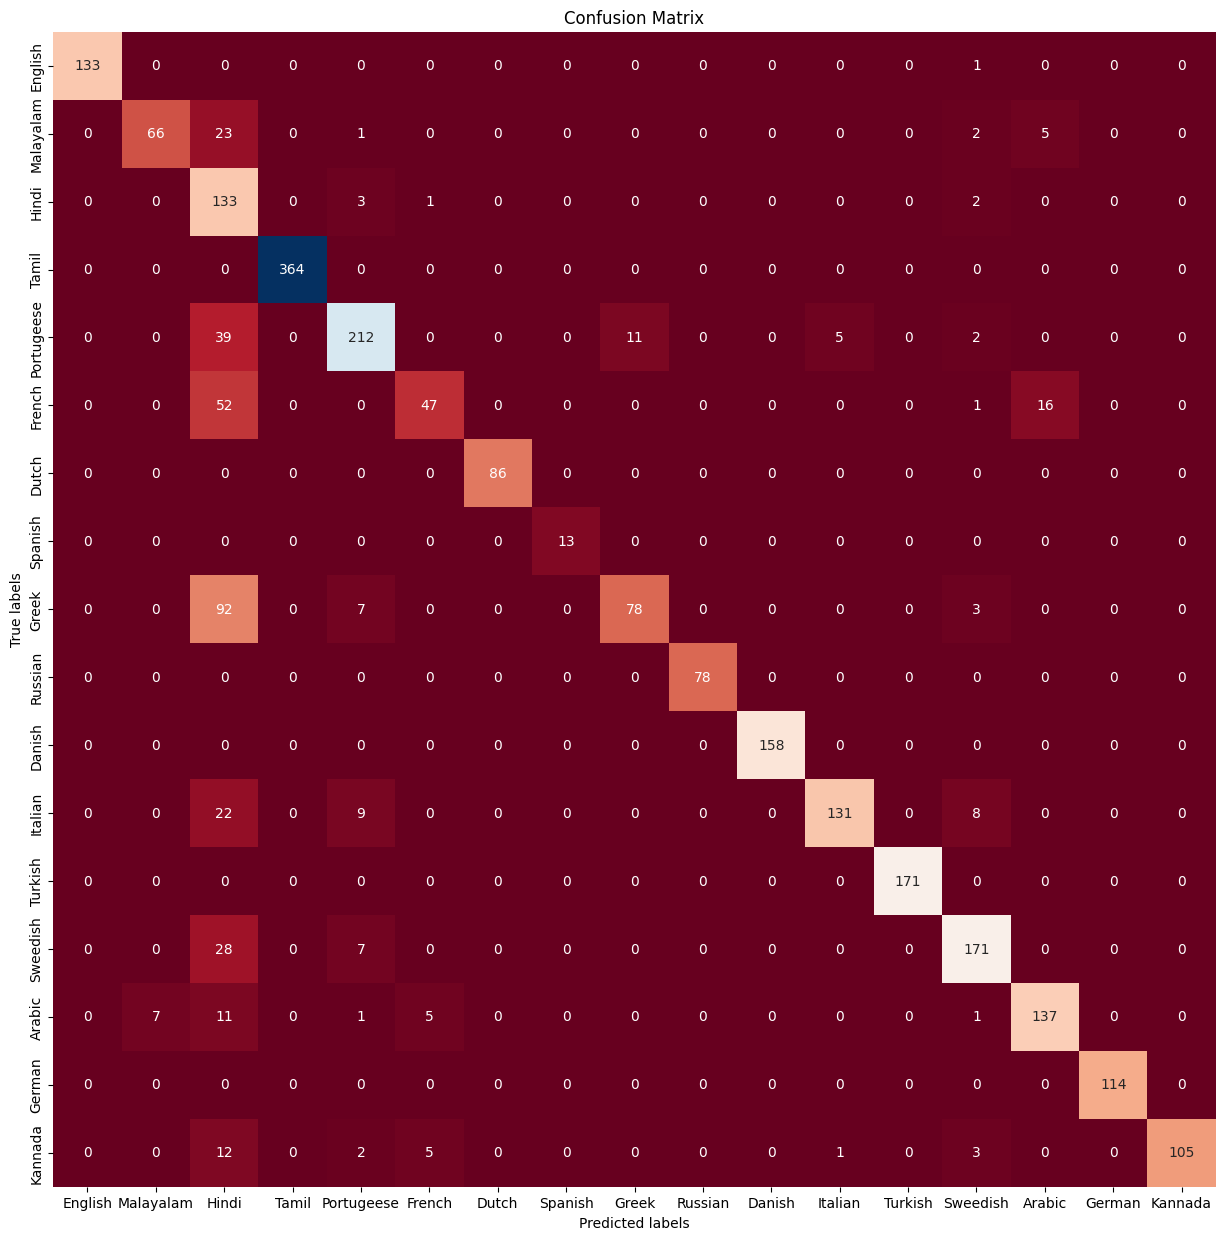

In [33]:
plt.figure(figsize=(15,15))
ax= plt.subplot()
sns.heatmap(cm2, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(d.keys())
ax.yaxis.set_ticklabels(d.keys())

Тут мы наблюдаем совершенно другую картину и понятно, что путаница возникает из-за предобработки текста.


Не могу до конца понять, почему так, но предобработка текста портит точность предсказаний и это факт.

Третья модель - **keras-model** с алгоритмом **back propagation**.

Эта модель будет самой умной из всех, что были до этого. Здесь уже действительно надо будет придумывать архитектуру нейросети именно с нуля, то есть думать насчет того, сколько скрытых слоёв будет и какими они будут.

Мы так же будет пользоваться эпохами, чтобы улучшить качество нашей нейросети за счет алгоритма обратного распространения ошибки (back propagation)

## Архитектура

Ну тут я не стал долго думать, потому что задача, которую мы будем решать не настолько сложна, чтобы тратить на неё очень много слоёв. Думаю, что хватит и 4 последовательных слоёв. (так как они последовательные, то буду использовать Sequential model)

Какими будут эти слои? Я решил попробовать сделать их полносвязными с прямым распространением, то есть обычный densely-connected NN layer.

Помимо всего этого, применим сглаживание входных данных, чтбобы не париться с тем, что у нас входные данные могут не поместиться по размерности во входной слой. (вот картинка)

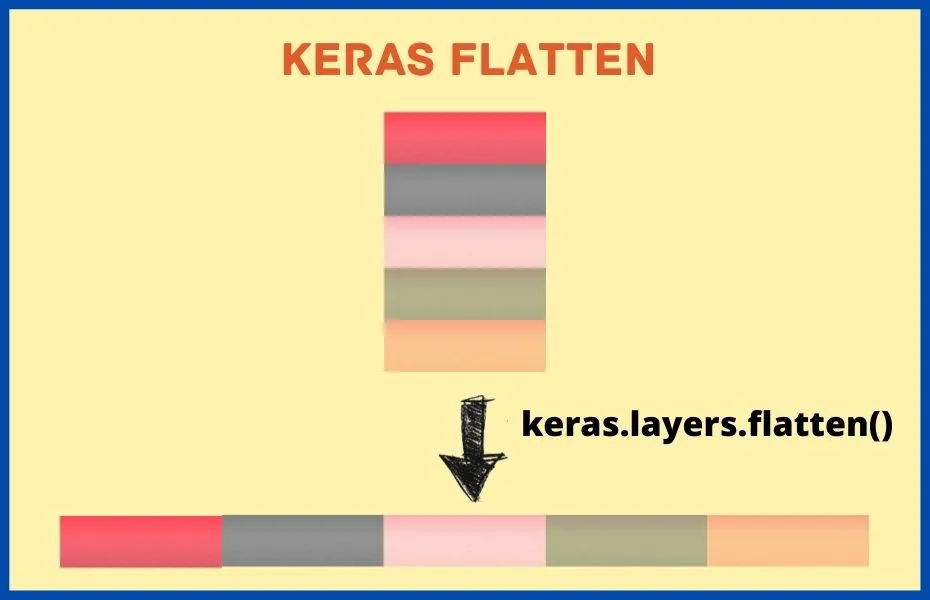

**Функция активации нейрона**

Тут самый простой вариант - это функция вида $f(x) = max(feature, 0)$.

Благо такая функция уже вшита в tensorflow и называется tf.nn.relu.

**Размерности слоёв**

На этом моменте я должен был перебирать размерности слоёв, пока не получил бы лучшую оценку качества, но, к сожалению, я перебирал очень долго, чтобы указывать все мои попытки, поэтому приведу финальный вариант, к которому я пришел.


Размерности слоёв:


1.   512
2.   256
3. 128
4. 17



Итого имеем:

In [34]:
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(256, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(17, activation=tf.nn.softmax)
                                   ])

## Выборки

Тут воспользуемся метрикой $TF-IDF$

In [35]:
tfid=TfidfVectorizer()
PipelineModel = Pipeline([('tfid',tfid)])
X1 = PipelineModel.fit_transform(dataset["Text"])
X1 = pd.DataFrame.sparse.from_spmatrix(X1)

In [36]:
X1

,0,1,2,3,4,5,6,7,8,9,...,39918,39919,39920,39921,39922,39923,39924,39925,39926,39927
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Это мы сделали X выборку, а теперь надо подготовить y выборку. Тут можно воспользоваться LabelEncoder, но мне слишком лень читать к нему мануал, поэтому сделаем что-то свое.

In [37]:
d={}
i=0
for word in pd.unique(y):
    d[word]=i
    i+=1
d

{'English': 0,
 'Malayalam': 1,
 'Hindi': 2,
 'Tamil': 3,
 'Portugeese': 4,
 'French': 5,
 'Dutch': 6,
 'Spanish': 7,
 'Greek': 8,
 'Russian': 9,
 'Danish': 10,
 'Italian': 11,
 'Turkish': 12,
 'Sweedish': 13,
 'Arabic': 14,
 'German': 15,
 'Kannada': 16}

Мы написали функцию для кодирования языка, потому что fit в keras не умеет работать со строковыми данными, однако, когда мы будем угадывать язык, то надо выводить уже строчку - название языка.

Так что надо написать функцию декодер.

In [38]:
def get_lang(n):
  for lang,num in d.items():
    if (num == n):
      return lang;

In [39]:
label=[]
for word in y:
    label.append(d[word])
label=pd.DataFrame(label,columns=['langauge'])
label

,langauge
0,0
1,0
2,0
3,0
4,0
...,...
10332,16
10333,16
10334,16
10335,16


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X1, label, test_size=0.1, random_state=33)

## Обучаем

Чтобы обучить модель с помощью метода fit, в keras надо задать несколько параметров в функции compile().

А именно:



1.   Оптимизатор - воспользуемся алгоритмом Адама
2.   Функция потерь - воспользуемся кросс-энтропией, только будем возвращать индекс самой подходящей категории а не вектор из энтропий каждой категории, то есть это будет sparse_categorical_crossentropy
3.   Метрика для мониторинга (опционально) - я буду использовать accuracy



In [41]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [42]:
history = model.fit(X_train, y_train, epochs=2)

Epoch 1/2
291/291 [==============================] - 56s 189ms/step - loss: 0.5843 - accuracy: 0.8463
Epoch 2/2
291/291 [==============================] - 56s 191ms/step - loss: 0.0229 - accuracy: 0.9949


In [43]:
prediction = model.predict(X_test)

33/33 [==============================] - 2s 47ms/step


In [44]:
ac3 = model.evaluate(X_test, y_test)[1]

33/33 [==============================] - 1s 28ms/step - loss: 0.0891 - accuracy: 0.9739


In [45]:
# хотим построить y_pred для confusion matrix и classification report
y_pred = []
for row in prediction:
  y_pred.append(np.argmax(row))

In [46]:
cr3 = classification_report(y_test,y_pred)

In [47]:
print("Accuracy is ", ac3)

Accuracy is  0.9738878011703491


In [48]:
print(cr3)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       138
           1       1.00      0.95      0.98        62
           2       1.00      1.00      1.00         6
           3       0.79      1.00      0.89        58
           4       0.95      0.96      0.96        79
           5       1.00      1.00      1.00       104
           6       1.00      1.00      1.00        42
           7       0.99      0.93      0.96        75
           8       1.00      0.97      0.99        36
           9       1.00      0.97      0.98        66
          10       0.93      0.95      0.94        42
          11       0.97      0.99      0.98        67
          12       1.00      0.93      0.97        61
          13       1.00      0.95      0.98        64
          14       1.00      1.00      1.00        43
          15       1.00      0.96      0.98        55
          16       1.00      1.00      1.00        36

    accuracy              

**Анализ ошибок**

Так же постром Confusion Matrix

In [49]:
cm3 = confusion_matrix(y_test, y_pred)

[Text(0, 0.5, 'English'),
 Text(0, 1.5, 'Malayalam'),
 Text(0, 2.5, 'Hindi'),
 Text(0, 3.5, 'Tamil'),
 Text(0, 4.5, 'Portugeese'),
 Text(0, 5.5, 'French'),
 Text(0, 6.5, 'Dutch'),
 Text(0, 7.5, 'Spanish'),
 Text(0, 8.5, 'Greek'),
 Text(0, 9.5, 'Russian'),
 Text(0, 10.5, 'Danish'),
 Text(0, 11.5, 'Italian'),
 Text(0, 12.5, 'Turkish'),
 Text(0, 13.5, 'Sweedish'),
 Text(0, 14.5, 'Arabic'),
 Text(0, 15.5, 'German'),
 Text(0, 16.5, 'Kannada')]

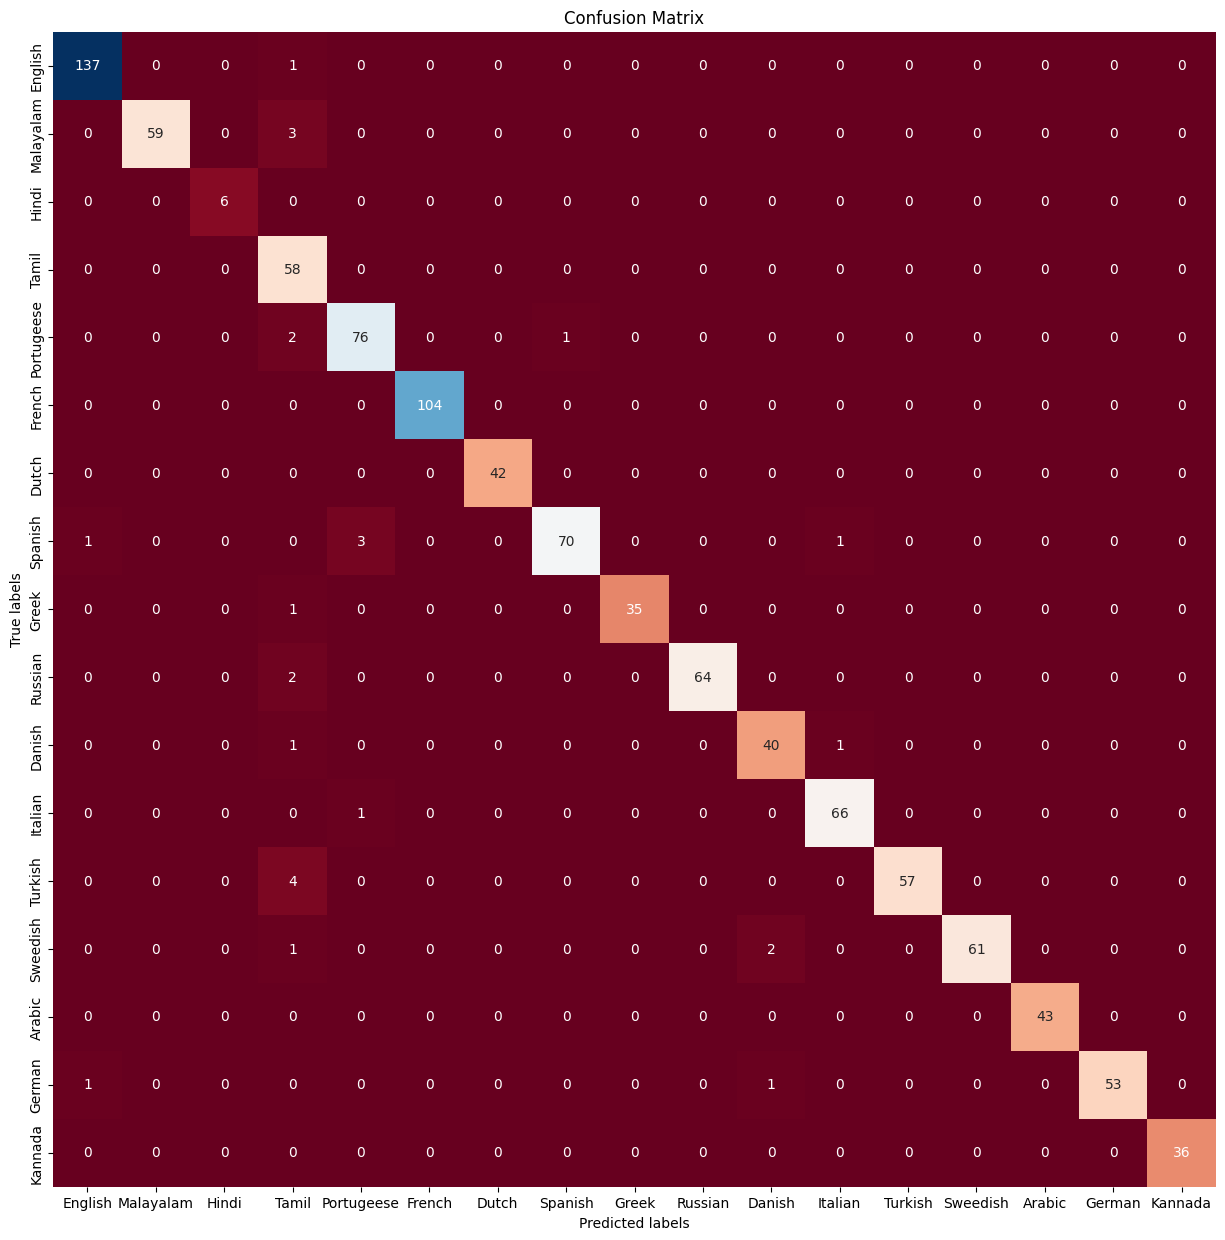

In [50]:
plt.figure(figsize=(15,15))
ax= plt.subplot()
sns.heatmap(cm3, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(d.keys())
ax.yaxis.set_ticklabels(d.keys())

Тут мы видим, что большинство языков нейросеть распознала правильно, но иногда путает некоторые языки


Решить эту проблеу можно по-разному, но самый простой вариант - это заняться оптимизацией гиперпараметров.

## Результаты

In [51]:
results = pd.DataFrame([ac1, ac2, ac3], index = ["Model 1",
                                "Model 2",
                                "Model 3"],
                       columns=["Accuracy"])
results

,Accuracy
Model 1,0.982592
Model 2,0.849903
Model 3,0.973888


Несмотря на то, что у первой модели точность лучше, я воспользуюсь третьей моделью, так как она была обучена более грамотно и имеет возможность дальнейшей оптимизации за счет изменения гиперпараметров.

In [52]:
def predict(sentence):
  sentence = PipelineModel.transform([sentence])
  sentence = pd.DataFrame.sparse.from_spmatrix(sentence)
  print(get_lang(np.argmax(model.predict(sentence))))

In [54]:
# English
predict("LANGUAGE DETECTION MODEL CHECK")
# French
predict("VÉRIFICATION DU MODÈLE DE DÉTECTION DE LA LANGUE")
# Arabic
predict("توففحص نموذج الكشف عن اللغة")
# Spanish
predict("VERIFICACIÓN DEL MODELO DE DETECCIÓN DE IDIOMAS")
# Malayalam
predict("ലാംഗ്വേജ് ഡിറ്റക്ഷൻ മോഡൽ ചെക്ക്")
# Russian
predict("ПРОВЕРКА МОДЕЛИ ОПРЕДЕЛЕНИЯ ЯЗЫКА")
# Hindi
predict('भाषा का पता लगाने वाले मॉडल की जांच')
# Hindi
predict(' boyit9h एनालिटिक्स alhgserog 90980879809 bguytfivb ahgseporiga प्रदान करता है')

1/1 [==============================] - 0s 51ms/step
English
1/1 [==============================] - 0s 112ms/step
French
1/1 [==============================] - 0s 43ms/step
Arabic
1/1 [==============================] - 0s 20ms/step
Spanish
1/1 [==============================] - 0s 20ms/step
Malayalam
1/1 [==============================] - 0s 22ms/step
Russian
1/1 [==============================] - 0s 20ms/step
Hindi
1/1 [==============================] - 0s 21ms/step
Turkish


Последнее предложение иногда определяет как Турецкий, это можно поправить засчет оптимизации гиперпараметров.

## Оптимизация гиперпараметров

Это больше относится к последней модели конечно, но тут можно попробовать поменять следующие гиперпараметры:




*   Оптимизатор
*   Функцию активации нейрона
*   Количество эпох обучения



